In [2]:
import numpy as np
import matplotlib.pyplot as plt
from thesis_functions import build_generator_matrix, calculate_and_order_eigenspectrum

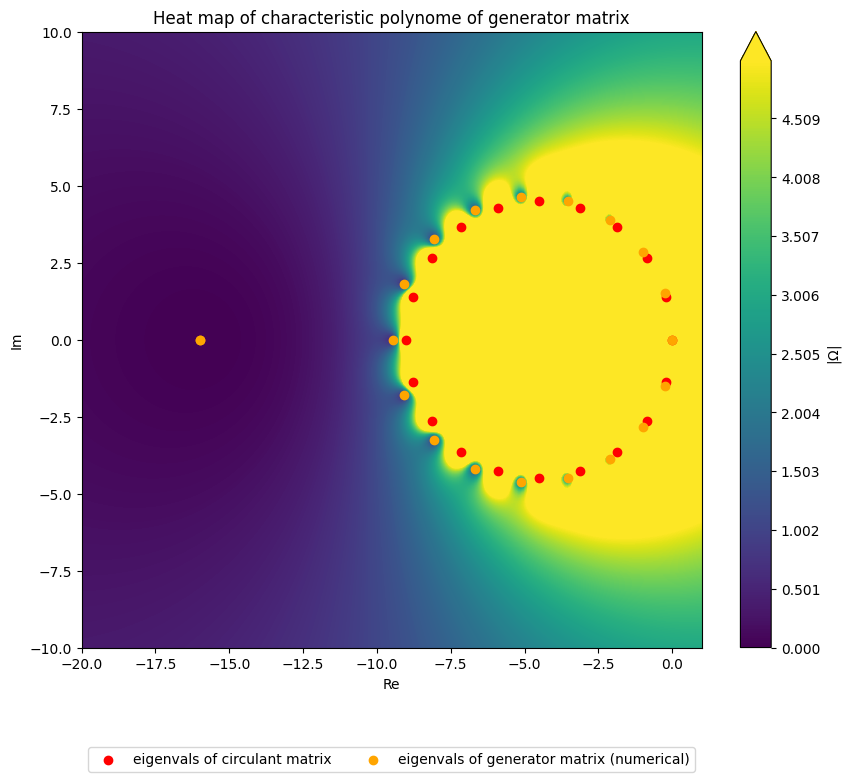

In [32]:
### This code visualizes the function whose zeros give the exact eigenvalues of my generator matrix

#Number of substates in each chain
N = 10
M = 10
#transition rates at end of each chain
r_ab = 16
r_ba = 16
refractory_periods = [2,2]
r = (N-1)/refractory_periods[0]

# Correct generator matrix with eigenspectrum
number_of_substates = [N,M]
transition_rates = [r_ab,r_ba]
#Build generator matrix
L = build_generator_matrix(number_of_substates,transition_rates,refractory_periods)
eigenvals,Q,P = calculate_and_order_eigenspectrum(L)


roots_of_unity = np.array([np.exp(-(2*np.pi*1j*k)/(N+M)) for k in range(N+M)])
roots_of_circulant_matrix = -r*np.ones(len(roots_of_unity)) + r*roots_of_unity

def omega(x):
    W_11 = 0
    W_22 = 0
    W_12 = 0
    W_21 = 0

    for j in range(N+M):
        phi_j = (2*np.pi*j)/(N+M)
        W_11 += (1-np.exp(-1j*phi_j))/(roots_of_circulant_matrix[j]-x)
        W_22 += (1-np.exp(-1j*phi_j))/(roots_of_circulant_matrix[j]-x)
        W_12 += (np.exp(-1j*phi_j*M)) * (1-np.exp(-1j*phi_j))/(roots_of_circulant_matrix[j]-x)
        W_21 += (np.exp(1j*phi_j*M)) * (1-np.exp(-1j*phi_j))/(roots_of_circulant_matrix[j]-x)

    W_11 = (r-r_ab)/(N+M) * W_11
    W_22 = (r-r_ba)/(N+M) * W_22
    W_12 = (r-r_ba)/(N+M) * W_12
    W_21 = (r-r_ab)/(N+M) * W_21

    return (1+W_11)*(1+W_22) - W_12 * W_21

n_sampling = 200

Re = np.linspace(-20,1,n_sampling)
Im = np.linspace(-10,10,n_sampling)

RE, IM = np.meshgrid(Re, Im)

Z = RE + IM * 1j

# Compute Omega on grid
W_grid = np.zeros_like(Z)
for i in range(n_sampling):
    for j in range(n_sampling):
        W_grid[i,j] = omega(Z[i,j])

my_levels = np.linspace(0, 5, 500)

plt.rcParams["figure.figsize"] = [10,8]
plt.contourf(RE, IM, np.abs(W_grid), cmap ='viridis', levels= my_levels, vmin = 0, vmax = 5,  extend='max')
plt.colorbar(label='$|\Omega|$')
plt.scatter(roots_of_circulant_matrix.real, roots_of_circulant_matrix.imag, color='red', label='eigenvals of circulant matrix')
plt.scatter(eigenvals.real, eigenvals.imag, color = 'orange', label='eigenvals of generator matrix (numerical)')
plt.xlabel('Re')
plt.ylabel('Im')
plt.legend(
    loc='upper center',       
    bbox_to_anchor=(0.5, -0.15), 
    ncol=2 
) 
plt.title('Heat map of characteristic polynome of generator matrix')                  
plt.show()



In [33]:
import numpy as np

def verify_summation(N, r, lam):
    """
    Compares the brute-force summation with the closed-form analytic solution.
    """
    # 1. Brute Force Calculation
    # --------------------------
    # Generate indices j from 1 to N/2
    j = np.arange(1, N//2 + 1)
    
    # Calculate angles theta_j = 2*pi*(2j-1)/N
    theta = (2 * np.pi * (2 * j - 1)) / N
    
    # Calculate z terms: exp(-i * theta)
    z_vals = np.exp(-1j * theta)
    
    # Compute the term for each j
    # T(z) = (1 - z) / (-r + r*z - lambda)
    numerator = 1 - z_vals
    denominator = -r + r * z_vals - lam
    
    terms = numerator / denominator
    
    # Sum and divide by N
    S_brute_force = (1/N) * np.sum(terms)

    # 2. Closed-Form Analytic Solution
    # --------------------------------
    # S = -1/(2r) + (lambda / (2r^2)) * (z_p^(N/2 - 1) / (z_p^(N/2) + 1))
    # where z_p = 1 + lambda/r
    
    z_p = 1 + lam/r
    M = N // 2  # This is N/2
    
    analytic_term = (z_p**(M - 1)) / (z_p**M + 1)
    S_closed_form = -1/(2*r) + (lam / (2 * r**2)) * analytic_term

    return S_brute_force, S_closed_form

# Parameters to test
test_cases = [
    (10, 2.0, 0.5),    # Small N
    (100, 1.5, 1.0),   # Larger N
    (50, 5.0, 0.1),    # Large r, small lambda
    (20, 0.5, 2.0)     # Small r, large lambda
]

print(f"{'N':<5} {'r':<5} {'lam':<5} | {'Brute Force':<25} | {'Closed Form':<25} | {'Difference':<10}")
print("-" * 85)

for N, r, lam in test_cases:
    bf, cf = verify_summation(N, r, lam)
    # We take the real part for display (imaginary part is ~1e-18 due to float noise)
    diff = abs(bf - cf)
    print(f"{N:<5} {r:<5} {lam:<5} | {bf.real:.15f}           | {cf:.15f}           | {diff:.2e}")

N     r     lam   | Brute Force               | Closed Form               | Difference
-------------------------------------------------------------------------------------
10    2.0   0.5   | -0.212340322969390           | -0.212340322969390           | 2.83e-17
100   1.5   1.0   | -0.200000000001078           | -0.200000000001078           | 2.78e-17
50    5.0   0.1   | -0.098781766569608           | -0.098781766569608           | 1.39e-18
20    0.5   2.0   | -0.200000081919992           | -0.200000081919992           | 8.33e-18
